# Audio Analysis

In [1]:
# link backend
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append('/home/darkangel/ai-light-show/backend')
from backend.config import SONGS_TEMP_DIR, SONGS_DIR

# sample song 
song_name = 'born_slippy'
songs_folder = "/home/darkangel/ai-light-show/songs/"
song_file = f"{songs_folder}{song_name}.mp3"
print(f"song: {song_name} | {song_file}")

# load metadata
from backend.models.song_metadata import SongMetadata
song = SongMetadata(song_name=song_name, songs_folder=songs_folder)
print(f"song metadata: {song}")


song: born_slippy | /home/darkangel/ai-light-show/songs/born_slippy.mp3
song metadata: SongMetadata(song_name=born_slippy, title=born slippy, genre=unknown, bpm=139.99, duration=135.7786865234375, beats=325, arrangement=10)


In [2]:
from backend.ai.demucs_split import extract_stems
stems_folder = extract_stems(song_file)

drums_path = f"{stems_folder['output_folder']}/drums.wav"

🎵 Extracting stems from the song...


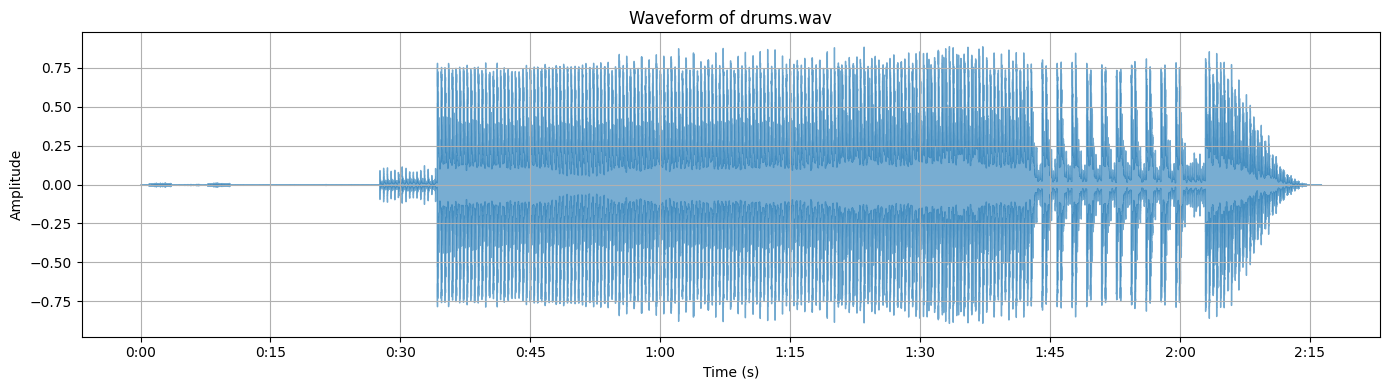

In [3]:
!pip install matplotlib --quiet
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# 🔍 Plot waveform
plt.figure(figsize=(14, 4))
y, sr = librosa.load(drums_path, sr=16000, mono=True)
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform of drums.wav")
plt.xlabel("Time (s)")

num_points = len(y)
times = np.linspace(0, num_points / sr, num_points)
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
from backend.ai.pattern_finder import get_stem_clusters
found_clusters = get_stem_clusters(song.get_beats_array(), drums_path)

/home/darkangel/.pyenv/versions/3.10.17/envs/ai-light/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/darkangel/.pyenv/versions/3.10.17/envs/ai-light/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/darkangel/.pyenv/versions/3.10.17/envs/ai-light/lib/python3.10/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/darkangel/.pyenv/versions/3.10.17/envs/ai-light/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/darkangel/.pyenv/versions/3.10.17/envs/ai-light/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/darkangel/.pyenv

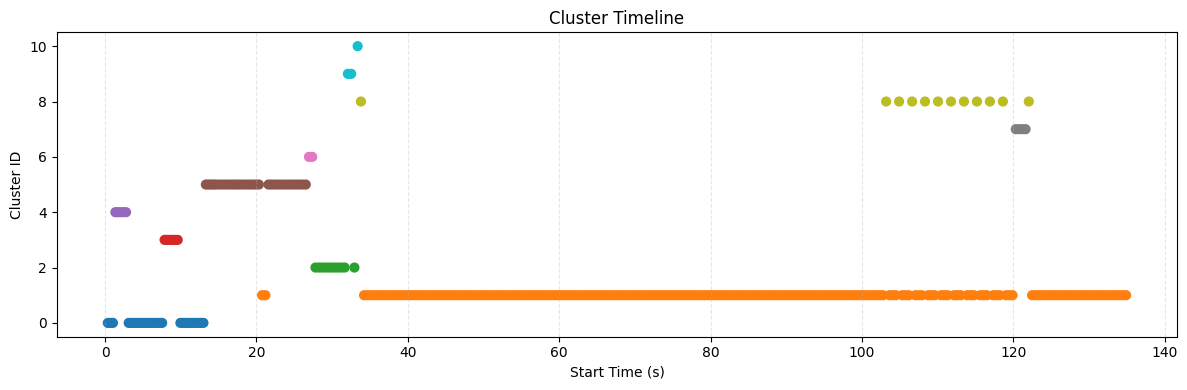

In [5]:
import matplotlib.pyplot as plt

# Extract start times and cluster ids
starts = [item['start'] for item in found_clusters['clusters_timeline']]
clusters = [item['cluster'] for item in found_clusters['clusters_timeline']]

plt.figure(figsize=(12, 4))
plt.scatter(starts, clusters, c=clusters, cmap='tab10', s=40)
plt.xlabel("Start Time (s)")
plt.ylabel("Cluster ID")
plt.title("Cluster Timeline")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Plot spectrogram
S = librosa.stft(y, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of drums.wav')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

In [ ]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torch, librosa, numpy as np

model_name = "yojul/wav2vec2-base-one-shot-hip-hop-drums-clf"
feat = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)

y, sr = librosa.load(drums_path, sr=16000, mono=True)
window, hop = int(0.1*sr), int(0.05*sr)
events = []

for start in range(0, len(y)-window, hop):
    chunk = y[start:start+window]
    inputs = feat(chunk, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
    label = model.config.id2label[np.argmax(probs)]
    conf = float(np.max(probs))
    if conf > 0.6:  # tune down if needed
        events.append({"time": (start+window/2)/sr, "type": label, "confidence": conf})

print(events[:10])


In [ ]:
# group events by type
drums_events = []
unique_types = set(e['type'] for e in events)
for t in unique_types:
    drums_events.append({
        "type": t,
        "time": [(e['time'], e['confidence']) for e in events if e['type'] == t]
        })

for e in drums_events:
    print(f"{e['type']}: {len(e['time'])} events")

In [ ]:
# merge events that are close in time, keep the one with highest confidence
# asume that an event shuld have a maximun duration of 0.5 seconds
max_duration = 0.5
merged_events = []
for e in drums_events:
    merged_time = []
    current_time = None
    current_confidence = 0.0
    
    for t, conf in sorted(e['time'], key=lambda x: x[0]):
        if current_time is None:
            current_time = t
            current_confidence = conf
        elif t - current_time <= max_duration:
            if conf > current_confidence:
                current_confidence = conf
        else:
            merged_time.append((current_time, current_confidence))
            current_time = t
            current_confidence = conf
            
    if current_time is not None:
        merged_time.append((current_time, current_confidence))
    
    merged_events.append({
        "type": e['type'],
        "time": merged_time
    })

# render only "kick"
plt.figure(figsize=(20, 6))
for e in [a for a in merged_events if a['type'] == '808S'] :
    times = [t[0] for t in e['time']]
    confs = [t[1] for t in e['time']]
    plt.plot(times, confs, label=e['type'])
plt.xlabel("Time (s)")
plt.ylabel("Confidence")
plt.title("Merged Drum Events Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install seaborn --quiet
import numpy as np
import pandas as pd

# Convert events to a DataFrame
df = pd.DataFrame(events)
pivot_df = df.pivot_table(index="type", columns="time", values="confidence", aggfunc="max", fill_value=0)
pivot_df

# Plot the heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="YlOrBr", annot=True, fmt=".2f", cbar_kws={'label': 'Confidence'})
plt.title("Drum Events Heatmap")
plt.xlabel("Time (s)")
plt.ylabel("Drum Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Fix deprecated np.complex for compatibility with librosa
if not hasattr(np, 'complex'):
    np.complex = complex

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
log_S = librosa.power_to_db(S, ref=np.max)

# Display Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram (drums.wav)")
plt.tight_layout()
plt.show()


In [ ]:
# Normalize columns of the spectrogram
norm_log_S = log_S / np.linalg.norm(log_S, axis=0, keepdims=True)

# Compute cosine similarity matrix
similarity_matrix = np.dot(norm_log_S.T, norm_log_S)


In [ ]:

# Plot self-similarity matrix
plt.figure(figsize=(8, 8))
librosa.display.specshow(similarity_matrix, x_axis='time', y_axis='time', sr=sr, hop_length=512)
plt.title("Self-Similarity Matrix (drums.wav)")
plt.colorbar(label='Cosine Similarity')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import soundfile as sf  # for writing WAV files

def save_wav(filename, audio, sr):
    """Save audio to a WAV file."""
    sf.write(filename, audio, sr)

# Patch numpy for deprecated types
if not hasattr(np, 'complex'):
    np.complex = complex
if not hasattr(np, 'float'):
    np.float = float

# Compute Mel spectrogram
hop_length = 2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000, hop_length=hop_length)
log_S = librosa.power_to_db(S, ref=np.max)

# Cluster features
features = log_S.T
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = clustering.fit_predict(features)

# ---  Extract and save one excerpt per cluster ID ---
unique_clusters = np.unique(cluster_labels)

for cluster_id in unique_clusters:
    start_frame = None
    end_frame = None

    for i in range(len(cluster_labels)):
        if cluster_labels[i] == cluster_id:
            if start_frame is None:
                start_frame = i
            end_frame = i
        elif start_frame is not None:
            break  # first complete segment done

    if start_frame is not None and end_frame is not None:
        start_sample = start_frame * hop_length
        end_sample = (end_frame + 1) * hop_length
        excerpt = y[start_sample:end_sample]
        filename = f"{stems_folder['output_folder']}/drums_{cluster_id}.wav"
        save_wav(filename, excerpt, sr)
        print(f"Saved cluster {cluster_id} region to '{filename}'")
    else:
        print(f"Cluster {cluster_id} not found in data.")


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from kneed import KneeLocator
import numpy as np

# Step 1: Subsample features for threshold estimation
step = 10
features_sampled = features[::step]

# Step 2: Linkage matrix and distance extraction
Z = linkage(features_sampled, method='ward')
merge_distances = Z[:, 2]

# Step 3: Use KneeLocator to find the elbow (threshold)
x = np.arange(len(merge_distances))
knee = KneeLocator(x, merge_distances, curve='convex', direction='increasing')
suggested_threshold = merge_distances[knee.knee] if knee.knee is not None else 20.0  # fallback

print(f"Using distance_threshold = {suggested_threshold:.2f}")

# Step 4: Full-resolution clustering using dynamic threshold
clustering = AgglomerativeClustering(
    distance_threshold=suggested_threshold,
    n_clusters=None,
    linkage='ward'
)
cluster_labels = clustering.fit_predict(features)

print(f"Discovered {len(set(cluster_labels))} clusters.")

In [ ]:
# Helper to convert frame index to time
def frame_to_time(frame_idx, hop_length=2048, sr=22050):
    return frame_idx * hop_length / sr

# Group consecutive frames with the same cluster label
regions = []
start = 0
current_label = cluster_labels[0]

for i in range(1, len(cluster_labels)):
    if cluster_labels[i] != current_label:
        start_time = frame_to_time(start)
        end_time = frame_to_time(i)
        regions.append([round(start_time, 2), round(end_time, 2), int(current_label)])
        start = i
        current_label = cluster_labels[i]

# Add the last region
regions.append([
    round(frame_to_time(start), 2),
    round(frame_to_time(len(cluster_labels)), 2),
    int(current_label)
])

# Display regions
import pandas as pd
df = pd.DataFrame(regions, columns=["start_time", "end_time", "cluster_id"])
df


In [ ]:
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform with Clustered Regions and Labels")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Overlay colored regions and add labels
colors = plt.cm.tab10(np.linspace(0, 1, len(set(cluster_labels))))

for start, end, cluster_id in regions:
    color = colors[cluster_id % len(colors)]
    # Draw semi-transparent block
    rect = patches.Rectangle((start, -1), end - start, 2, color=color, alpha=0.3)
    plt.gca().add_patch(rect)
    # Add cluster label in the middle of the block
    mid = (start + end) / 2
    plt.text(mid, 0.9, str(cluster_id), ha='center', va='center', fontsize=9, weight='bold')

# X-axis: time labels
plt.xticks(np.arange(0, max([r[1] for r in regions]), step=5))
plt.xlim(0, max([r[1] for r in regions]))
plt.grid(True, axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
!pip install kneed --quiet
from scipy.cluster.hierarchy import linkage
from kneed import KneeLocator
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Subsample for speed
step = 10
features_sampled = features[::step]

# Step 2: Linkage
Z = linkage(features_sampled, method='ward')
merge_distances = Z[:, 2]

# Step 3: Detect elbow using KneeLocator
x = np.arange(len(merge_distances))
knee = KneeLocator(x, merge_distances, curve='convex', direction='increasing')
suggested_threshold = merge_distances[knee.knee] if knee.knee is not None else None

# Step 4: Plot
plt.figure(figsize=(10, 4))
plt.plot(x, merge_distances, label="Merge distances")
if suggested_threshold:
    plt.axvline(x=knee.knee, color='r', linestyle='--', label="Knee point")
    plt.axhline(y=suggested_threshold, color='g', linestyle='--', label=f"Suggested threshold ≈ {suggested_threshold:.2f}")
else:
    plt.text(0.5, 0.5, "No knee found", transform=plt.gca().transAxes)
plt.title("Dendrogram Merge Distances (KneeLocator)")
plt.xlabel("Merge step")
plt.ylabel("Distance")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Suggested distance threshold (KneeLocator): {suggested_threshold:.2f}" if suggested_threshold else "No clear knee found.")


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

# Patch numpy for deprecated types
if not hasattr(np, 'complex'):
    np.complex = complex
if not hasattr(np, 'float'):
    np.float = float

# Compute Mel spectrogram with larger hop length to reduce frame count
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000, hop_length=2048)
log_S = librosa.power_to_db(S, ref=np.max)

# Transpose spectrogram to get feature vectors per time frame
features = log_S.T  # shape: (frames, features)

# Cluster frames based on spectral similarity
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = clustering.fit_predict(features)

In [ ]:

# Visualize clustering result as a color-coded timeline
plt.figure(figsize=(12, 2))
plt.title("Cluster Labels Over Time (first 30s of drums.wav)")
sns.heatmap([cluster_labels], cmap="tab10", cbar=True, xticklabels=False, yticklabels=False)
plt.xlabel("Frame Index")
plt.tight_layout()
plt.show()


In [ ]:
!pip install pydub --quiet
# save an audio sample of each cluster (the first one, from start_time to end_time)
import os
from pydub import AudioSegment
def save_cluster_samples(df, audio_path, output_folder, stem_prefix="cluster_"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    audio = AudioSegment.from_wav(audio_path)
    
    for index, row in df.iterrows():
        start_time = int(row['start_time'] * 1000)  # convert to milliseconds
        end_time = int(row['end_time'] * 1000)      # convert to milliseconds
        cluster_id = row['cluster_id']
        
        sample = audio[start_time:end_time]
        sample.export(f"{output_folder}/{stem_prefix}{cluster_id}.wav", format="wav")

save_cluster_samples(df, drums_path, f"{stems_folder['output_folder']}", stem_prefix="drums_")
print(f"Save {max(df['cluster_id'])+1} cluster/s samples to {stems_folder['output_folder']}")

In [ ]:
# create a tuple with the cluster_id and the start_time
cluster_tuples = [(row['start_time'], int(row['cluster_id'])) for _, row in df.iterrows()]

# sort the tuples by start_time
cluster_tuples.sort(key=lambda x: x[0])

# Display the sorted tuplesx
print(cluster_tuples)
